# Energy Demand Prediction/ Forecasting (Power Sector) 

Built a predictive model to forecast electricity demand. 

### Data Source
jawad, Mohammed Saeed (2023), “SEWA Electricity Demand Forecasting -- 2020 and 2021”, Mendeley Data, V2, doi: 10.17632/4rjc87zrd3.2

https://data.mendeley.com/datasets/4rjc87zrd3/2

### Loading Dataset and Setting up libraries

In [1]:
#importing necessary libraries

#for data handling and manipulation
import pandas as pd
import numpy as np

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#for model development
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor

#for model evaluations
from sklearn.metrics import mean_squared_error, r2_score

#for saving model
import joblib

#warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
#loading dataset
df = pd.read_csv('SEWA_energy.csv')
df.sample(12)

,Date,Day,MAX Tem,Min Tem,Max Hum,Min Hum,Temp,Hum,SEWA MIN LOAD(MW),SEWA Peak Load(MW),SEWA Energy/hr.
355,22-Dec,Wednesday,28 C,17 C,79%,39%,21 C,50%,838.0,1129,998.0
46,16-Feb,Tuesday,30 C,13 C,97%,29%,20 C,66%,719.0,985,860.0
251,09-Sep,Thursday,43 C,30 C,86%,16%,32 C,88%,1752.0,2321,2067.0
70,12-Mar,Friday,38 C,17 C,51%,8%,23 C,39%,822.0,1112,989.0
113,24-Apr,Saturday,40 C,21 C,68%,6%,27 C,43%,1181.0,1632,1433.0
135,16-May,Sunday,42 C,24 C,77%,8%,29 C,35%,1362.0,1899,1676.0
25,26-Jan,Tuesday,25 C,13 C,91%,37%,18 C,99%,642.0,937,789.0
349,16-Dec,Thursday,28 C,14 C,76%,28%,20 C,43%,826.0,1077,930.0
28,29-Jan,Friday,28 C,10 C,76%,25%,17 C,77%,640.0,840,751.0
53,23-Feb,Tuesday,28 C,16 C,80%,36%,21 C,52%,814.0,1053,945.0


## Data Cleaning

In [3]:
new_column_names = ['Date', 'Day', 'Max_Tem', 'Min_Tem', 'Max_Hum', 'Min_Hum', 
                    'Avg_Temp', 'Avg_Hum', 'Min_Load', 'Max_Load', 'Avg_Energy/hr']

#renaming columns for better understanding of the data throughout
df.rename(columns=dict(zip(df.columns, new_column_names)), inplace=True)

Removing missing values:

- removing missing values from the dataset as the total number of missing values is less than 5% of the entire dataset

Checking for duplicated rows:

- No duplicated rows found

In [4]:
# Handling missing values
print(df.isna().sum())
df.dropna(inplace=True)
print(df.isna().sum())

Date             0
Day              0
Max_Tem          3
Min_Tem          3
Max_Hum          3
Min_Hum          3
Avg_Temp         2
Avg_Hum          2
Min_Load         2
Max_Load         0
Avg_Energy/hr    2
dtype: int64
Date             0
Day              0
Max_Tem          0
Min_Tem          0
Max_Hum          0
Min_Hum          0
Avg_Temp         0
Avg_Hum          0
Min_Load         0
Max_Load         0
Avg_Energy/hr    0
dtype: int64


In [5]:
duplicated_rows = len(df[df.duplicated()==True]) #checking for duplicated rows
print('Duplicated Rows present in the dataset:',duplicated_rows)
df.info()

Duplicated Rows present in the dataset: 0
<class 'pandas.core.frame.DataFrame'>
Index: 362 entries, 0 to 361
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           362 non-null    object 
 1   Day            362 non-null    object 
 2   Max_Tem        362 non-null    object 
 3   Min_Tem        362 non-null    object 
 4   Max_Hum        362 non-null    object 
 5   Min_Hum        362 non-null    object 
 6   Avg_Temp       362 non-null    object 
 7   Avg_Hum        362 non-null    object 
 8   Min_Load       362 non-null    float64
 9   Max_Load       362 non-null    int64  
 10  Avg_Energy/hr  362 non-null    float64
dtypes: float64(2), int64(1), object(8)
memory usage: 33.9+ KB


Correcting Data type:
- All temperature columns ('Max_Tem','Min_Tem','Avg_Temp') have C representing celsius in the data, removing C and then converting the values to dtype int
- All Humidity columns ('Max_Hum','Min_Hum','Avg_Hum') have % in the data, removing the % and then converting the values to dtype int

In [6]:
#Removing 'C' from temperature columns and converting them to dtype int
df['Max_Tem'] = df['Max_Tem'].str.replace(' C', '').astype(int)
df['Min_Tem'] = df['Min_Tem'].str.replace(' C', '').astype(int)
df['Avg_Temp'] = df['Avg_Temp'].str.replace(' C', '').astype(int)

#Removing '%' from humidity columns and converting them to dtype int
df['Max_Hum'] = df['Max_Hum'].str.replace('%', '').astype(int)
df['Min_Hum'] = df['Min_Hum'].str.replace('%', '').astype(int)
df['Avg_Hum'] = df['Avg_Hum'].str.replace('%', '').astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362 entries, 0 to 361
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           362 non-null    object 
 1   Day            362 non-null    object 
 2   Max_Tem        362 non-null    int32  
 3   Min_Tem        362 non-null    int32  
 4   Max_Hum        362 non-null    int32  
 5   Min_Hum        362 non-null    int32  
 6   Avg_Temp       362 non-null    int32  
 7   Avg_Hum        362 non-null    int32  
 8   Min_Load       362 non-null    float64
 9   Max_Load       362 non-null    int64  
 10  Avg_Energy/hr  362 non-null    float64
dtypes: float64(2), int32(6), int64(1), object(2)
memory usage: 25.5+ KB


## Exploratory Data Analysis

In [8]:
df.describe()

,Max_Tem,Min_Tem,Max_Hum,Min_Hum,Avg_Temp,Avg_Hum,Min_Load,Max_Load,Avg_Energy/hr
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.00000,362.000000,362.000000
mean,35.751381,22.417127,78.908840,23.906077,27.245856,55.886740,1262.91989,1669.718232,1483.314917
std,6.694278,6.750400,44.049267,11.020606,5.787827,38.361827,416.57999,541.453597,480.231512
min,12.000000,6.000000,36.000000,4.000000,15.000000,2.000000,591.00000,806.000000,706.000000
25%,30.000000,17.000000,69.250000,15.000000,22.000000,39.000000,859.75000,1112.750000,1002.500000
50%,37.000000,22.000000,78.000000,23.000000,28.000000,52.000000,1273.00000,1659.000000,1473.500000
75%,42.000000,28.000000,85.750000,32.000000,32.000000,67.000000,1668.75000,2227.000000,1970.000000
max,49.000000,51.000000,881.000000,53.000000,38.000000,647.000000,2124.00000,2487.000000,2212.000000


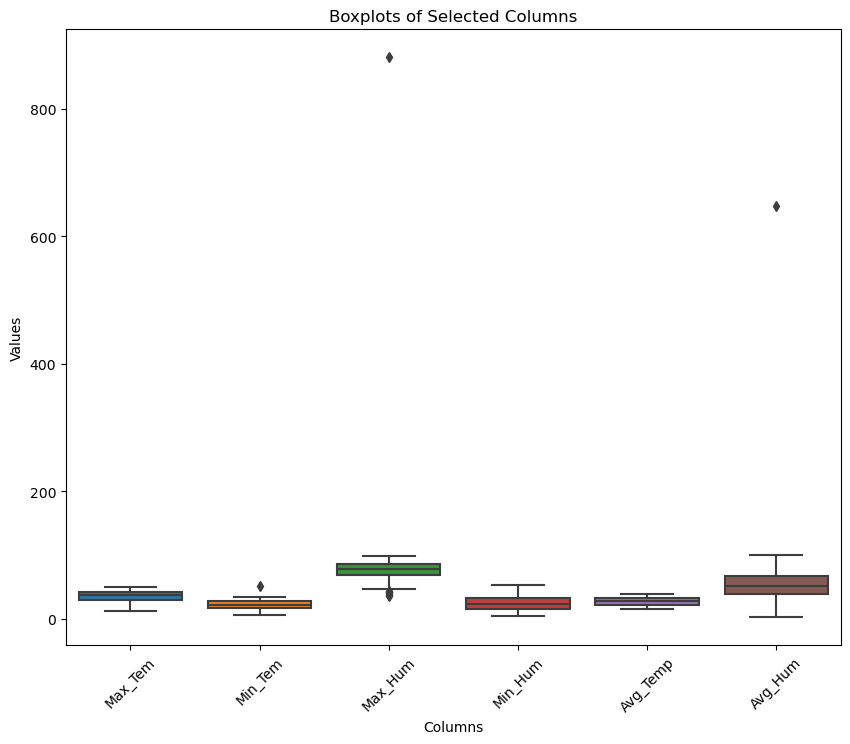

In [9]:
columns_to_plot = ["Max_Tem", "Min_Tem", "Max_Hum", "Min_Hum", "Avg_Temp", "Avg_Hum"]

# Plot boxplots for each selected column
plt.figure(figsize=(10, 8))
sns.boxplot(data=df[columns_to_plot])
plt.title("Boxplots of Selected Columns")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

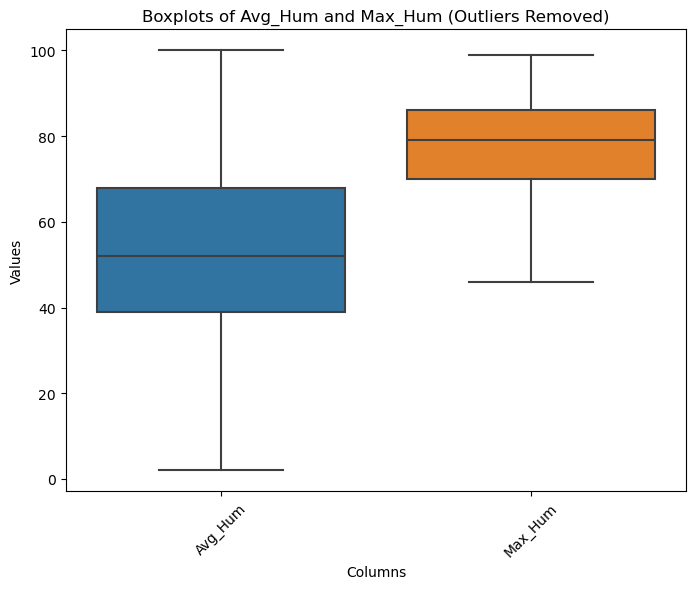

In [10]:
# Calculate the IQR (Interquartile Range) for Avg_Hum and Max_Hum
Q1 = df['Avg_Hum'].quantile(0.25)
Q3 = df['Avg_Hum'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound_avg_hum = Q1 - 1.5 * IQR
upper_bound_avg_hum = Q3 + 1.5 * IQR

# Filter out the outliers from Avg_Hum
df_filtered = df[(df['Avg_Hum'] >= lower_bound_avg_hum) & (df['Avg_Hum'] <= upper_bound_avg_hum)]

# Repeat the same process for Max_Hum
Q1 = df['Max_Hum'].quantile(0.25)
Q3 = df['Max_Hum'].quantile(0.75)
IQR = Q3 - Q1

lower_bound_max_hum = Q1 - 1.5 * IQR
upper_bound_max_hum = Q3 + 1.5 * IQR

df_filtered = df_filtered[(df_filtered['Max_Hum'] >= lower_bound_max_hum) & (df_filtered['Max_Hum'] <= upper_bound_max_hum)]

# Plot boxplots for the filtered columns
plt.figure(figsize=(8,6))
sns.boxplot(data=df_filtered[['Avg_Hum', 'Max_Hum']])
plt.title("Boxplots of Avg_Hum and Max_Hum (Outliers Removed)")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()


In [11]:
df = df_filtered.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           353 non-null    object 
 1   Day            353 non-null    object 
 2   Max_Tem        353 non-null    int32  
 3   Min_Tem        353 non-null    int32  
 4   Max_Hum        353 non-null    int32  
 5   Min_Hum        353 non-null    int32  
 6   Avg_Temp       353 non-null    int32  
 7   Avg_Hum        353 non-null    int32  
 8   Min_Load       353 non-null    float64
 9   Max_Load       353 non-null    int64  
 10  Avg_Energy/hr  353 non-null    float64
dtypes: float64(2), int32(6), int64(1), object(2)
memory usage: 22.2+ KB


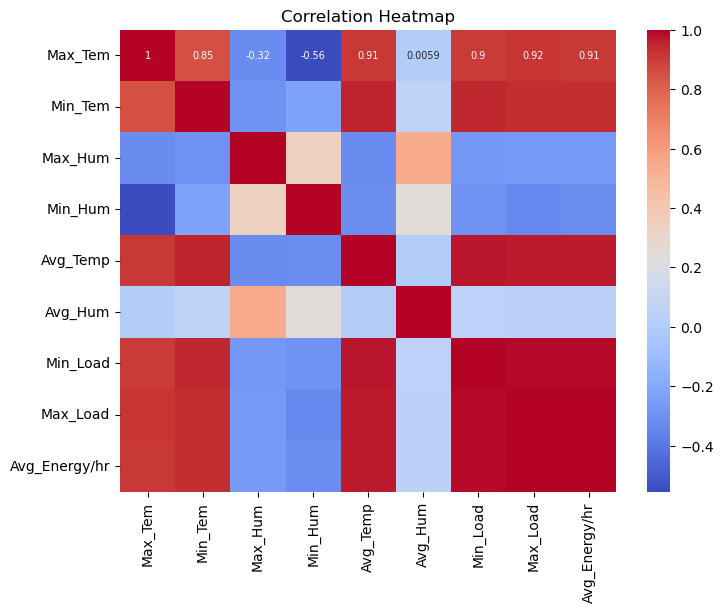

In [12]:
corr_matrix = df.drop(['Date', 'Day'], axis=1).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, cmap='coolwarm',annot=True,annot_kws={'size':7})
plt.title('Correlation Heatmap')
plt.show()

In [13]:
corr_matrix

,Max_Tem,Min_Tem,Max_Hum,Min_Hum,Avg_Temp,Avg_Hum,Min_Load,Max_Load,Avg_Energy/hr
Max_Tem,1.000000,0.848328,-0.324642,-0.555581,0.911050,0.005903,0.903620,0.918246,0.911294
Min_Tem,0.848328,1.000000,-0.290298,-0.225306,0.952391,0.059127,0.946233,0.933726,0.937183
Max_Hum,-0.324642,-0.290298,1.000000,0.338553,-0.319885,0.542489,-0.271481,-0.269673,-0.261619
Min_Hum,-0.555581,-0.225306,0.338553,1.000000,-0.318563,0.242806,-0.298781,-0.334513,-0.317586
Avg_Temp,0.911050,0.952391,-0.319885,-0.318563,1.000000,0.007817,0.972904,0.964648,0.965196
Avg_Hum,0.005903,0.059127,0.542489,0.242806,0.007817,1.000000,0.048199,0.043563,0.042771
Min_Load,0.903620,0.946233,-0.271481,-0.298781,0.972904,0.048199,1.000000,0.988105,0.990060
Max_Load,0.918246,0.933726,-0.269673,-0.334513,0.964648,0.043563,0.988105,1.000000,0.994632
Avg_Energy/hr,0.911294,0.937183,-0.261619,-0.317586,0.965196,0.042771,0.990060,0.994632,1.000000


Analysis of Average conditions with Average Energy load


<Figure size 800x600 with 0 Axes>

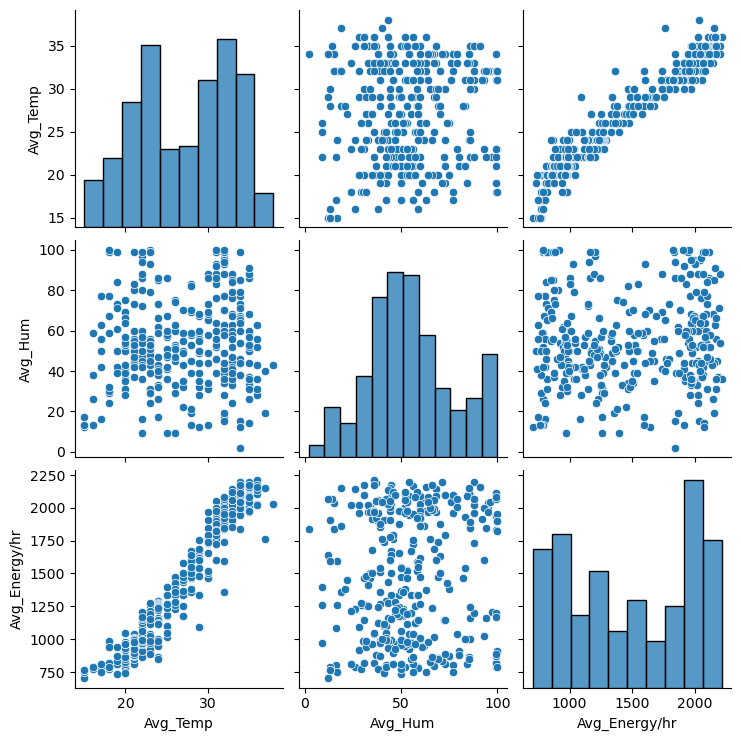

In [14]:
numeric_columns = ['Max_Tem', 'Min_Tem', 'Max_Hum', 'Min_Hum', 'Avg_Temp', 'Avg_Hum', 'Min_Load', 'Max_Load', 'Avg_Energy/hr']
avg_columns = ['Avg_Temp', 'Avg_Hum','Avg_Energy/hr']
min_columns = ['Min_Tem','Min_Hum', 'Min_Load']
max_columns = ['Max_Tem','Max_Hum','Max_Load']
# Perform univariate analysis using pairplot
plt.figure(figsize=(8,6))
print('Analysis of Average conditions with Average Energy load')
sns.pairplot(df[avg_columns])
# plt.tight_layout()
plt.show()

Analysis of Minimum conditions (temperature, humidity) with Minimum Energy load


<Figure size 800x600 with 0 Axes>

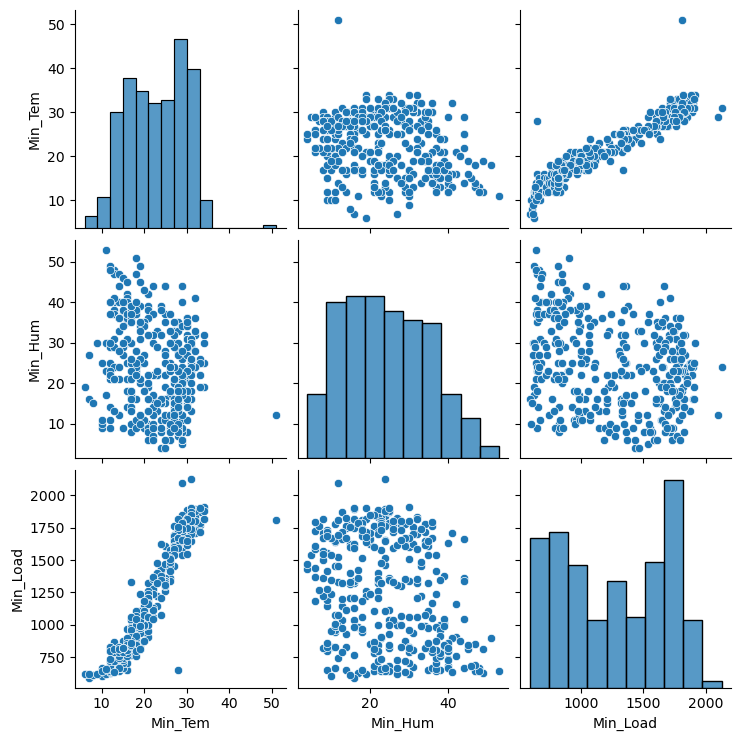

In [15]:
plt.figure(figsize=(8,6))
print('Analysis of Minimum conditions (temperature, humidity) with Minimum Energy load')
sns.pairplot(df[min_columns])
plt.show()

Analysis of Maximum conditions (temperature, humidity) with Maximum Energy load


<Figure size 800x600 with 0 Axes>

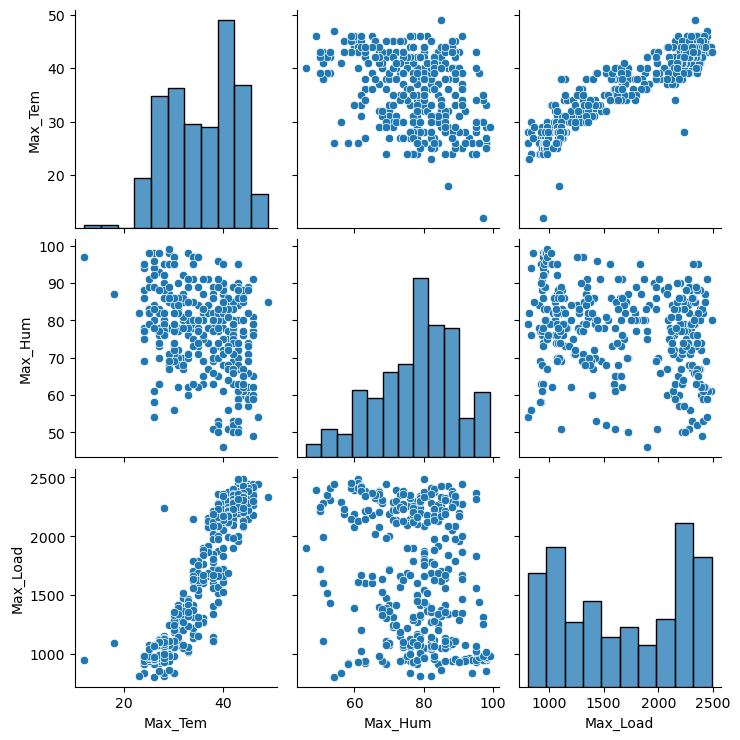

In [16]:
plt.figure(figsize=(8,6))
print('Analysis of Maximum conditions (temperature, humidity) with Maximum Energy load')
sns.pairplot(df[max_columns])
plt.show()

## Data Preprocessing

In [17]:
#extracting month from the date column
df['Month'] = pd.to_datetime(df['Date'], format='%d-%b').dt.month

#categorizing months into 4 seasons
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Summer', 4: 'Summer', 5: 'Summer',
    6: 'Monsoon', 7: 'Monsoon', 8: 'Monsoon', 
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

df['Season'] = df['Month'].map(season_map)
# dropping date and month column, as season column has been extracted from them
df.drop(['Date','Month'],axis=1,inplace=True) 

In [18]:
df.describe()

,Max_Tem,Min_Tem,Max_Hum,Min_Hum,Avg_Temp,Avg_Hum,Min_Load,Max_Load,Avg_Energy/hr
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,35.657224,22.393768,77.444759,24.169972,27.218130,54.631728,1263.133144,1670.104816,1483.478754
std,6.738526,6.805802,11.360714,10.982140,5.847543,22.458682,419.885275,545.817228,484.048205
min,12.000000,6.000000,46.000000,4.000000,15.000000,2.000000,591.000000,806.000000,706.000000
25%,30.000000,17.000000,70.000000,15.000000,22.000000,39.000000,855.000000,1110.000000,998.000000
50%,36.000000,22.000000,79.000000,23.000000,28.000000,52.000000,1302.000000,1659.000000,1473.000000
75%,42.000000,28.000000,86.000000,33.000000,32.000000,68.000000,1673.000000,2230.000000,1972.000000
max,49.000000,51.000000,99.000000,53.000000,38.000000,100.000000,2124.000000,2487.000000,2212.000000


In [19]:
df.head(10)

,Day,Max_Tem,Min_Tem,Max_Hum,Min_Hum,Avg_Temp,Avg_Hum,Min_Load,Max_Load,Avg_Energy/hr,Season
0,Friday,28,16,79,35,19,50,652.0,812,734.0,Winter
1,Saturday,28,14,76,21,19,42,643.0,936,802.0,Winter
2,Sunday,27,12,74,25,20,36,682.0,949,820.0,Winter
3,Monday,27,12,73,14,17,16,653.0,942,801.0,Winter
4,Tuesday,27,10,63,9,16,13,647.0,925,786.0,Winter
5,Wednesday,27,11,63,17,16,26,624.0,941,786.0,Winter
6,Thursday,26,11,58,23,20,52,646.0,924,785.0,Winter
7,Friday,26,10,54,10,15,12,604.0,806,706.0,Winter
8,Saturday,26,7,58,16,15,17,591.0,918,751.0,Winter
9,Sunday,26,8,61,15,15,13,611.0,933,768.0,Winter


## Model Development

In [21]:
X = df.drop(['Max_Tem', 'Min_Tem', 'Max_Hum', 'Min_Hum', 
                    'Min_Load', 'Max_Load', 'Avg_Energy/hr'],axis=1)
y = df['Avg_Energy/hr']

# Define the preprocessing for categorical features
categorical_features = ['Day', 'Season']
categorical_transformer = OneHotEncoder()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough'  # Leave the other columns untouched
)

# Define the pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) 
# Train the model
pipeline.fit(X_train, y_train)

# Save the model
joblib.dump(pipeline, 'energy_model.pkl')

['energy_model.pkl']

In [22]:
pipeline.score(X_test,y_test)

0.9667828457775423